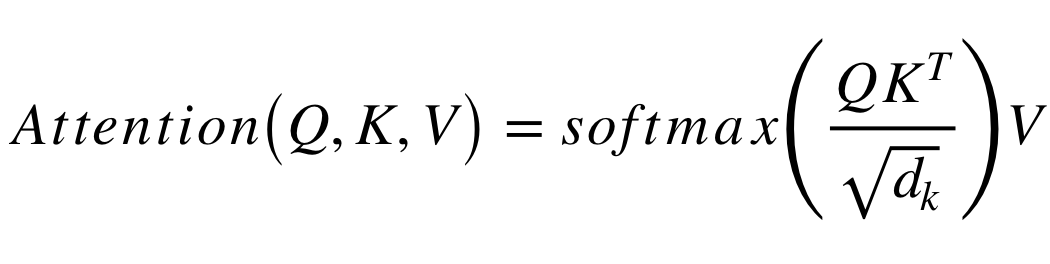

In [1]:
from IPython.display import Image
Image(filename='./images/qkv.png')

In [2]:
import torch
from torch import nn
import math
from bertviz.transformers_neuron_view import BertModel, BertConfig
from transformers import BertTokenizer

## 1. model config and load

In [3]:
max_length = 256
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name, output_attentions=True, 
                                    output_hidden_states=True, 
                                    return_dict=True)
tokenizer = BertTokenizer.from_pretrained(model_name)
config.max_position_embeddings = max_length

model = BertModel(config).from_pretrained(model_name)
model = model.eval()

In [4]:
model.config

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": true,
  "output_hidden_states": false,
  "pad_token_id": 0,
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [5]:
att_head_size = int(model.config.hidden_size/model.config.num_attention_heads)

In [6]:
att_head_size

64

In [21]:
model.encoder.layer[0].attention.self.query.weight.T[:, 64:128]

tensor([[-0.0112, -0.0324, -0.0615,  ..., -0.0383,  0.0031,  0.0059],
        [ 0.0260, -0.0067, -0.0616,  ...,  0.1097,  0.0029, -0.0540],
        [-0.0169,  0.0232,  0.0068,  ...,  0.0124, -0.0168,  0.0301],
        ...,
        [ 0.1083,  0.0056,  0.0968,  ...,  0.0188, -0.0171,  0.0141],
        [-0.0436, -0.1032, -0.1035,  ...,  0.0138, -0.0488, -0.0453],
        [-0.0611,  0.0224, -0.0320,  ...,  0.0376,  0.0186, -0.0482]],
       grad_fn=<SliceBackward0>)

## 2. data

In [22]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
inputs_tests = tokenizer(newsgroups_train['data'][:1], 
                         truncation=True, padding=True, max_length=max_length, 
                         return_tensors='pt')

/Users/chunhuizhang/anaconda3/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


In [25]:
inputs_tests['input_ids'].shape

torch.Size([1, 201])

In [37]:
inputs_tests.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

## 3. model output

In [26]:
model_output = model(**inputs_tests)

- last_hidden_state (batch_size, sequence_length, hidden_size) : last hidden state which is outputted from the last BertLayer
- pooler_output (batch_size, hidden_size) : output of the Pooler layer
- hidden_states (batch_size, sequence_length, hidden_size): hidden-states of the model at the output of each BertLayer plus the initial embedding
- attentions (batch_size, num_heads, sequence_length, sequence_length): one for each BertLayer. Attentions weights after the attention SoftMax

In [27]:
len(model_output)

3

In [31]:
model_output[-1][0].keys()

dict_keys(['attn', 'queries', 'keys'])

In [36]:
model_output[-1][0]['attn'][0, 0, :, :]

tensor([[0.0053, 0.0109, 0.0052,  ..., 0.0039, 0.0036, 0.0144],
        [0.0086, 0.0041, 0.0125,  ..., 0.0045, 0.0041, 0.0071],
        [0.0051, 0.0043, 0.0046,  ..., 0.0043, 0.0045, 0.0031],
        ...,
        [0.0010, 0.0023, 0.0055,  ..., 0.0012, 0.0018, 0.0011],
        [0.0010, 0.0023, 0.0057,  ..., 0.0012, 0.0017, 0.0007],
        [0.0022, 0.0056, 0.0063,  ..., 0.0045, 0.0048, 0.0015]],
       grad_fn=<SliceBackward0>)

## 4. from scratch

In [38]:
emb_output = model.embeddings(inputs_tests['input_ids'], inputs_tests['token_type_ids'])

In [39]:
emb_output.shape

torch.Size([1, 201, 768])

In [40]:
# model.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [42]:
# emb_output[0].shape: 201*768
# query.weight.T.shape: 768*768, query.weight.T[:, :att_head_size]: 768*64
# 201*64
Q_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.query.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.query.bias[:att_head_size]

In [44]:
# 201*64
K_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.key.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.key.bias[:att_head_size]

In [48]:
# (201*64)*(64*201) ==> 201*201
attn_scores = torch.nn.Softmax(dim=-1)(Q_first_head_first_layer @ K_first_head_first_layer.T / math.sqrt(att_head_size))

In [46]:
attn_scores

tensor([[0.0053, 0.0109, 0.0052,  ..., 0.0039, 0.0036, 0.0144],
        [0.0086, 0.0041, 0.0125,  ..., 0.0045, 0.0041, 0.0071],
        [0.0051, 0.0043, 0.0046,  ..., 0.0043, 0.0045, 0.0031],
        ...,
        [0.0010, 0.0023, 0.0055,  ..., 0.0012, 0.0018, 0.0011],
        [0.0010, 0.0023, 0.0057,  ..., 0.0012, 0.0017, 0.0007],
        [0.0022, 0.0056, 0.0063,  ..., 0.0045, 0.0048, 0.0015]],
       grad_fn=<SoftmaxBackward0>)

In [52]:
attn_scores.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [49]:
V_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.value.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.value.bias[:att_head_size]

In [50]:
attn_emb = attn_scores @ V_first_head_first_layer

In [51]:
attn_emb.shape

torch.Size([201, 64])

In [69]:
V_first_head_first_layer

tensor([[ 2.3786e+00, -9.7945e-02, -2.8436e-01,  ...,  9.6968e-02,
         -1.8537e-01,  2.1132e-01],
        [ 9.8886e-02,  2.2942e-01, -3.9613e-01,  ...,  2.0846e-01,
         -1.1224e-01, -2.1420e-01],
        [-6.3356e-01,  1.1083e+00, -5.2859e-04,  ..., -3.1870e-01,
          7.2633e-02, -1.0239e-01],
        ...,
        [-7.9659e-01, -4.9400e-01, -4.9216e-02,  ..., -3.6446e-01,
          3.1565e-01, -7.1713e-01],
        [-9.2551e-01, -5.0348e-01, -1.0398e-01,  ..., -2.1418e-01,
          1.6604e-01, -5.9637e-01],
        [ 1.2915e-01, -7.5900e-03,  1.8397e-01,  ...,  2.6980e-01,
          1.3651e-01,  1.9180e-01]], grad_fn=<AddBackward0>)

### 5. all

In [60]:
Q_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.query.weight.T \
                            + model.encoder.layer[0].attention.self.query.bias
K_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.key.weight.T \
                            + model.encoder.layer[0].attention.self.key.bias
V_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.value.weight.T \
                            + model.encoder.layer[0].attention.self.value.bias

In [61]:
scores = torch.nn.Softmax(dim=-1)(Q_first_layer @ K_first_layer.T / math.sqrt(64))

In [68]:
scores @ V_first_layer[:, :64]

tensor([[ 2.3786e+00, -9.7945e-02, -2.8436e-01,  ...,  9.6968e-02,
         -1.8537e-01,  2.1132e-01],
        [-6.2984e-01,  1.1037e+00, -2.0764e-04,  ..., -3.1767e-01,
          7.2197e-02, -1.0126e-01],
        [ 3.7932e-02,  2.9540e-01, -3.6121e-01,  ...,  1.6694e-01,
         -9.9637e-02, -2.0356e-01],
        ...,
        [-7.0623e-01, -3.0113e-01,  9.4959e-02,  ..., -1.7217e-01,
          1.8647e-01, -4.4743e-01],
        [ 6.2047e-02, -4.0626e-02,  1.6757e-01,  ...,  2.2690e-01,
          1.4684e-01,  1.3030e-01],
        [ 2.3748e+00, -9.7801e-02, -2.8357e-01,  ...,  9.7254e-02,
         -1.8481e-01,  2.1127e-01]], grad_fn=<MmBackward0>)